In [1]:
import os 
import matplotlib
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
import requests
import re
import datetime
import shap


from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM
import torch

currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
year = int(date.strftime("%Y"))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = "#949494"

%matplotlib inline

ModuleNotFoundError: No module named 'shap'

In [2]:
od.download('https://www.kaggle.com/c/playground-series-s4e9')
os.listdir('playground-series-s4e9')
train = pd.read_csv('playground-series-s4e9/train.csv', low_memory=False)
test = pd.read_csv('playground-series-s4e9/test.csv', low_memory=False)
sub = pd.read_csv('playground-series-s4e9/sample_submission.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading playground-series-s4e9.zip to ./playground-series-s4e9


100%|██████████| 7.84M/7.84M [00:00<00:00, 667MB/s]


Extracting archive ./playground-series-s4e9/playground-series-s4e9.zip to ./playground-series-s4e9


In [44]:
DATASET_DIR = 'playground-series-s4e9/'
DATASET_NAME = 'train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://www.kaggle.com/c/playground-series-s4e9'

In [70]:
N_THREADS = 16
N_FOLDS = 20
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600

In [71]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [72]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [73]:
data = pd.read_csv(DATASET_DIR + DATASET_NAME)

In [74]:
def convert_engine(val):
    d = {
        'engine_HP': np.nan,
        'engine_L': np.nan,
        'engine_cylinder': np.nan,
        'engine_cylinder_type': np.nan,
        'engine_fuel_type': np.nan,
        'engine_type': np.nan,
        'engine_v': np.nan,
        'engine_vtype': np.nan
    }
    spl = val.replace('-', '').split(' ')
    pos_v1 = -1
    pos_v2 = -1
    for i, v in enumerate(spl):
        if v.endswith('HP'):
            d['engine_HP'] = float(v[:-2])
        elif v.endswith('L'):
            d['engine_L'] = float(v[:-1])
        elif v == 'Engine' and spl[i-1] == 'Cylinder':
            d['engine_cylinder'] = abs(float(spl[i-2].replace('V', '')))
        elif v == 'Fuel':
            d['engine_fuel_type'] = spl[i - 1]
        elif v == 'Liter':
            d['engine_L'] = float(spl[i-1])
        elif v.startswith('V') or v.startswith('H') or v.startswith('I'):
            try:
                d['engine_cylinder'] = float(v[1:])
                d['engine_cylinder_type'] = v[0]
                pos_v1 = i
            except:
                pass
        elif v == 'DOHC' or v == 'OHV':
            d['engine_type'] = ' '.join(spl[i:])
            if pos_v2 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v2+1:i])
            elif pos_v1 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v1+1:i])
        elif v.endswith('V'):
            try:
                d['engine_v'] = float(v[:-1])
                pos_v2 = i
            except:
                pass
    return d

def test_params(ModelClass, **params):
    model = ModelClass(**params).fit(X_train, Y_train)
    train_rmse = rmse(model.predict(X_train), Y_train)
    val_rmse = rmse(model.predict(X_val), Y_val)
    return train_rmse, val_rmse


def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    for x,y in zip(param_values,val_errors):
        label = "{:.2f}".format(y)
        plt.annotate(label,
                    (x,y),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [75]:
average_prices_by_brand = data.groupby('brand')['price'].mean()

train = data.fillna('dash')
train = train.replace('–', 'dash')

test = test.fillna('dash')
test = test.replace('–', 'dash')

accident_dict = {
    'None reported': 0,
    'At least 1 accident or damage reported': 1,
    'uknown': 2
}

clean_title_dict = {
    'Yes': 0,
    'uknown': 1
}

expensive_ext_color = ['Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice',
       'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
       'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic',
       'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
       'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite',
       'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
       'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue',
       'Custom Color', 'Vega Blue', 'Designo Magno Matte',
       'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic',
       'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
       'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof',
       'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
       'Santorini Black Metallic', 'Quartzite Grey Metallic',
       'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona']

expensive_int_color = ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
                       'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']

inexpensive_ext_color = ['Gold', 'Frozen White', 'Beige', 'Volcanic Orange',
        'Mountain Air Metallic', 'Crystal Black Pearl', 'Crimson Red Tintcoat',
        'Snowflake White Pearl', 'Sonic Silver Metallic', 'Radiant Red Metallic II',
        'Remington Red Metallic', 'Gecko Pearlcoat', 'Dazzling White',
        'Blue Reflex Mica', 'White Platinum Tri-Coat Metallic', 'Purple',
        'Crystal White Pearl', 'Silver', 'Jet Black Mica', 'Red Quartz Tintcoat']

inexpensive_int_color =['Light Gray', 'Gray', 'Medium Pewter', 'Beige', 'Medium Ash Gray',
       'White / Brown', 'Ash', 'Deep Chestnut', 'Charcoal Black',
       'Whisper Beige', 'Gideon', 'Light Platinum / Jet Black', 'Sand Beige',
       'Mountain Brown', 'Ivory / Ebony', 'Black / Graphite', 'Canberra Beige',
       'Tupelo', 'Charcoal', 'Gold']

low_end_brand = average_prices_by_brand[average_prices_by_brand < 25000].index.tolist()
mid_range_brand = average_prices_by_brand[(average_prices_by_brand > 25000) & (average_prices_by_brand < 40000)].index.tolist()
high_end_brand = average_prices_by_brand[(average_prices_by_brand > 40000) & (average_prices_by_brand < 80000)].index.tolist()
luxury_brand = average_prices_by_brand[average_prices_by_brand > 80000].index.tolist()

def encode_columns(df):
    gases = df.fuel_type.value_counts().index
    for gas in gases:
        df.loc[(df['fuel_type'] == '–') & df['engine'].str.contains(gas), 'fuel_type'] = gas

    milage_per_year = df['milage'] / (year - df['model_year'])

    auto_transmission = df['transmission'].str.contains('A/T') + df['transmission'].str.contains(' At') + df['transmission'].str.contains('Automatic') + df['transmission'].str.contains('Dual Shift') + df['transmission'].str.contains('CVT Transmission') + df['transmission'].str.contains('CVT-F') + df['transmission'].str.contains('Overdrive Switch') + df['transmission'].str.contains('Variable')
    manual_transmission = df['transmission'].str.contains('M/T') + df['transmission'].str.contains(' Mt') + df['transmission'].str.contains('Manual')
    
    df['milage_per_year'] = milage_per_year.astype(int)
    
    df['auto_transmission'] = auto_transmission.astype(int)
    df['manual_transmission'] = manual_transmission.astype(int)

    df['turbo_engine'] = df['engine'].str.contains('Turbo').astype(int)
    df['supercharged_engine'] = df['engine'].str.contains('Supercharged').astype(int)
    df['dohc_engine'] = df['engine'].str.contains('DOHC').astype(int)
    df['ohv_engine'] = df['engine'].str.contains('OHV').astype(int)


    df['low_end_brand'] = df.brand.isin(low_end_brand).astype(int)
    df['mid_range_brand'] = df.brand.isin(mid_range_brand).astype(int)
    df['high_end_brand'] = df.brand.isin(high_end_brand).astype(int)
    df['luxury_brand'] = df.brand.isin(luxury_brand).astype(int)

    df['accident_encoded'] = df['accident'].map(accident_dict)
    df['clean_title_encoded'] = df['clean_title'].map(clean_title_dict)
    df['expensive_color_ext_encoded'] = df.ext_col.isin(expensive_ext_color).astype(int)
    df['expensive_color_int_encoded'] = df.int_col.isin(expensive_int_color).astype(int)
    df['inexpensive_color_ext_encoded'] = df.ext_col.isin(inexpensive_ext_color).astype(int)
    df['inexpensive_color_int_encoded'] = df.int_col.isin(inexpensive_int_color).astype(int)

    df['engine_fuel_type'].replace('dash', np.nan)
    df['engine_fuel_type'] = df.engine_fuel_type.fillna(df['fuel_type'])
    df['engine_fuel_type'] = df.engine_fuel_type.replace('Flexible', 'Flex').replace('E85 Flex Fuel', 'Flex')

    df['engine_HP_per_L'] = df['engine_HP']/df['engine_L']
    
    return df

train = pd.concat([train, pd.DataFrame.from_records(train['engine'].map(convert_engine).values)], axis = 1)
test = pd.concat([test, pd.DataFrame.from_records(test['engine'].map(convert_engine).values)], axis = 1)


train = encode_columns(train)
test = encode_columns(test)

ValueError: Columns must be same length as key

In [ ]:
INPUT_COLS = ['model_year', 'milage', 'milage_per_year', 'engine_fuel_type', 
       'low_end_brand', 'mid_range_brand', 'high_end_brand', 'luxury_brand', 
       'turbo_engine', 'dohc_engine', 'supercharged_engine', 'ohv_engine',
       'accident_encoded', 'clean_title_encoded', 
       'inexpensive_color_int_encoded', 'inexpensive_color_ext_encoded',
       'expensive_color_ext_encoded', 'expensive_color_int_encoded', 
       'auto_transmission', 'manual_transmission', 'engine_HP', 'engine_L', 'engine_HP_per_L',
       'engine_cylinder', 'engine_cylinder_type', 'engine_v', 'engine_vtype']

TARGET_NAME = 'price'

train_data, val_data = train_test_split(train, test_size=TEST_SIZE, stratify=train[TARGET_NAME] ,random_state=RANDOM_STATE)

In [ ]:
task = Task('reg', loss='rmse', metric='rmse')

In [76]:
roles = {
    'target': TARGET_NAME,
    'drop' : ['id']
}

In [77]:
automl = TabularAutoML(task = task,
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[19:52:34] Stdout logging level is INFO.
[19:52:34] Task: reg

[19:52:34] Start automl preset with listed constraints:
[19:52:34] - time: 3600.00 seconds
[19:52:34] - CPU: 16 cores
[19:52:34] - memory: 16 GB

[19:52:34] Train data shape: (150826, 39)

[19:52:41] Layer 1 train process start. Time left 3593.37 secs
[19:52:45] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:53:18] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5376921600.0
[19:53:18] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:53:18] Time left 3556.48 secs

[19:53:19] Selector_LightGBM fitting and predicting completed
[19:53:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:54:00] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -5242009088.0
[19:54:00] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:54:00] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


In [ ]:
val_preds = automl.predict(val_data)
print(f'Prediction for test_data:\n{val_preds}\nShape = {val_preds.shape}')

Prediction for test_data:
array([[38589.863],
       [52396.758],
       [66704.45 ],
       ...,
       [17265.297],
       [73421.65 ],
       [48394.766]], dtype=float32)
Shape = (37707, 1)


In [ ]:
oof_rmse = rmse(train_data[TARGET_NAME].values, out_of_fold_predictions.data)
holdout_rmse = rmse(val_data[TARGET_NAME].values, val_preds.data)

print(f'OOF RMSE: {oof_rmse}')
print(f'HOLDOUT RMSE: {holdout_rmse}')

OOF RMSE: 72477.3203125
HOLDOUT RMSE: 72494.28125


In [58]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.05095 * (10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.21855 * (10 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.36172 * (10 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.36878 * (10 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [59]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [60]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[19:16:31] Stdout logging level is INFO.
[19:16:31] Task: reg

[19:16:31] Start automl preset with listed constraints:
[19:16:31] - time: 3600.00 seconds
[19:16:31] - CPU: 16 cores
[19:16:31] - memory: 16 GB

[19:16:31] Train data shape: (150826, 39)

[19:16:38] Layer 1 train process start. Time left 3593.58 secs
[19:16:42] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:16:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -5375575040.0
[19:16:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:16:57] Time left 3574.66 secs

[19:16:58] Selector_LightGBM fitting and predicting completed
[19:17:02] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:17:16] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -5286777856.0
[19:17:16] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:17:16] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [03:40<00:00,  2.19s/it, best_trial=33, best_value=-5.83e+9]

[19:20:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:20:57] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[19:21:20] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -5282065920.0
[19:21:20] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[19:21:20] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[19:21:33] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -5291741696.0
[19:21:33] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[19:21:33] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [02:24<00:00,  1.43s/it, best_trial=95, best_value=-5.88e+9]

[19:23:58] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[19:23:58] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[19:24:14] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -5279347200.0
[19:24:14] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[19:24:14] Time left 3137.36 secs

[19:24:14] Layer 1 training completed.

[19:24:14] Blending: optimization starts with equal weights. Score = -5258572800.0000000
[19:24:14] Blending: iteration 0: score = -5253459968.0000000, weights = [0.         0.21169502 0.3628216  0.14872432 0.27675903]
[19:24:14] Blending: iteration 1: score = -5253207040.0000000, weights = [0.05058644 0.2293517  0.33141237 0.13584934 0.25280017]
[19:24:14] Blending: iteration 2: score = -5252912640.0000000, weights = [0.05587469 0.21486019 0.35970923 0.06057933 0.30897656]
[19:24:14] Blending: iteration 3: score = -5252899328.0000000, weights = [0.05079325 0.2189345  0.35965234 0.05706811 0.31355175]
[19:24:14] Blending: iteration 4: score = -5252840960.0000000, weights = [0.05221593 0.2199736  0.36271912 0.         0.36509138]
[19:24:14] Blending: be

In [61]:
!ls tabularAutoML_model_report

feature_importance.png	      test_target_distribution_1.png
lama_interactive_report.html  valid_error_hist.png
test_error_hist_1.png	      valid_scatter_plot.png
test_scatter_plot_1.png       valid_target_distribution.png


In [62]:
val_preds = automl_rd.predict(val_data)
print(f'Prediction for test_data:\n{val_preds}\nShape = {val_preds.shape}')

Prediction for test_data:
array([[38563.844],
       [52440.82 ],
       [66766.734],
       ...,
       [17293.656],
       [73404.72 ],
       [48379.46 ]], dtype=float32)
Shape = (37707, 1)


In [63]:
oof_rmse = rmse(train_data[TARGET_NAME].values, out_of_fold_predictions.data)
holdout_rmse = rmse(val_data[TARGET_NAME].values, val_preds.data)

print(f'OOF RMSE: {oof_rmse}')
print(f'HOLDOUT RMSE: {holdout_rmse}')

OOF RMSE: 72476.484375
HOLDOUT RMSE: 72494.15625


<Axes: xlabel='Feature'>

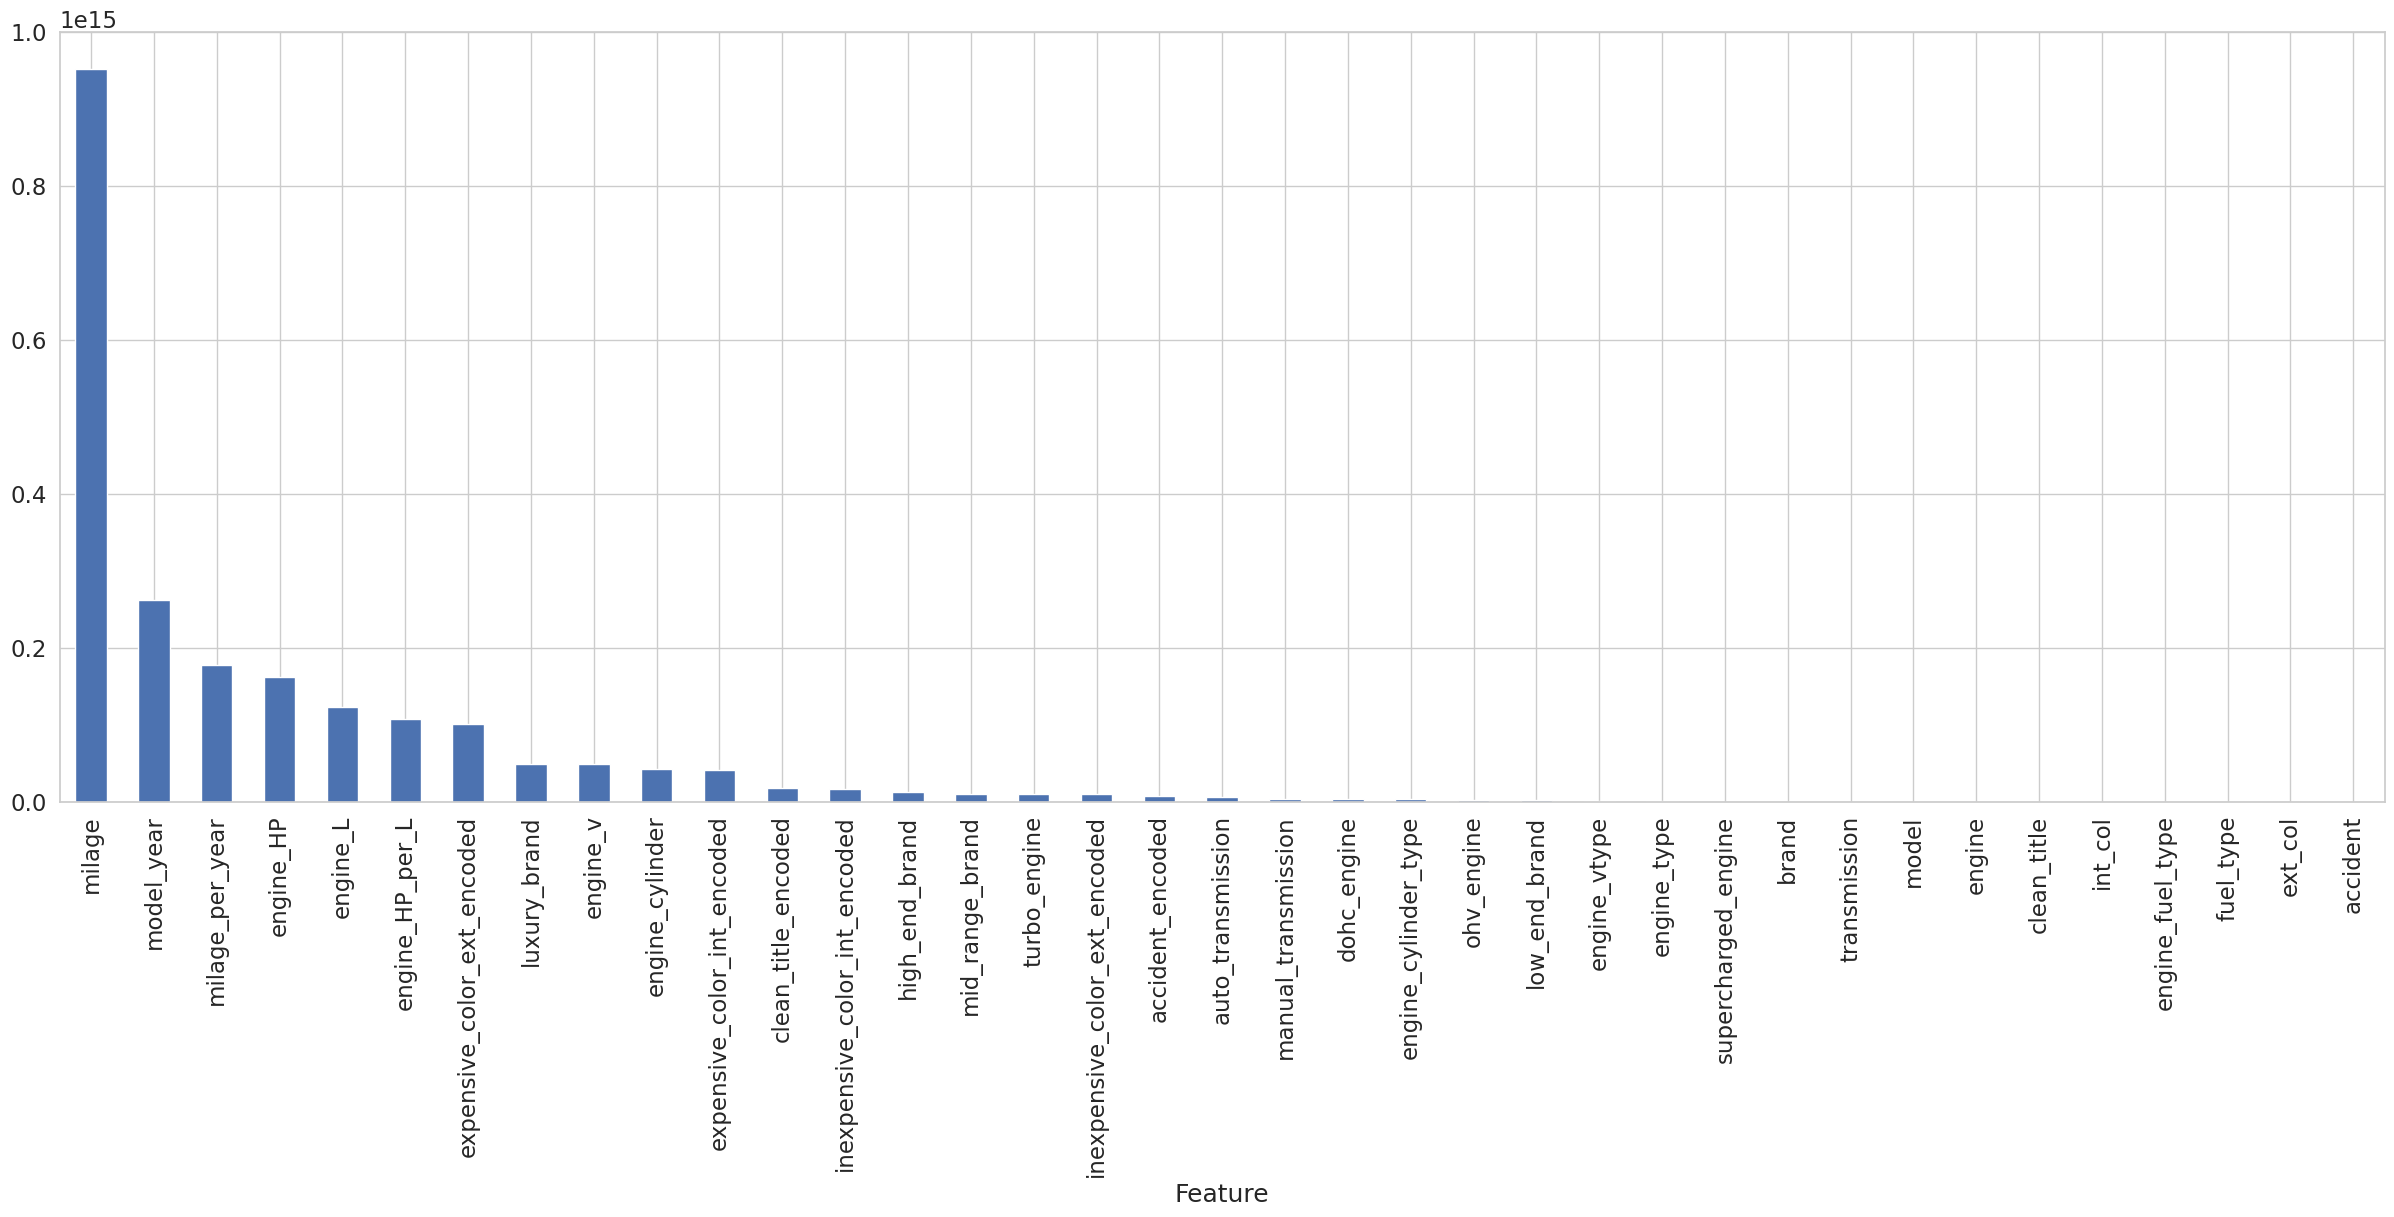

In [64]:
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [65]:
accurate_fi = automl_rd.model.get_feature_scores('accurate', val_data, silent = True)

<Axes: xlabel='Feature'>

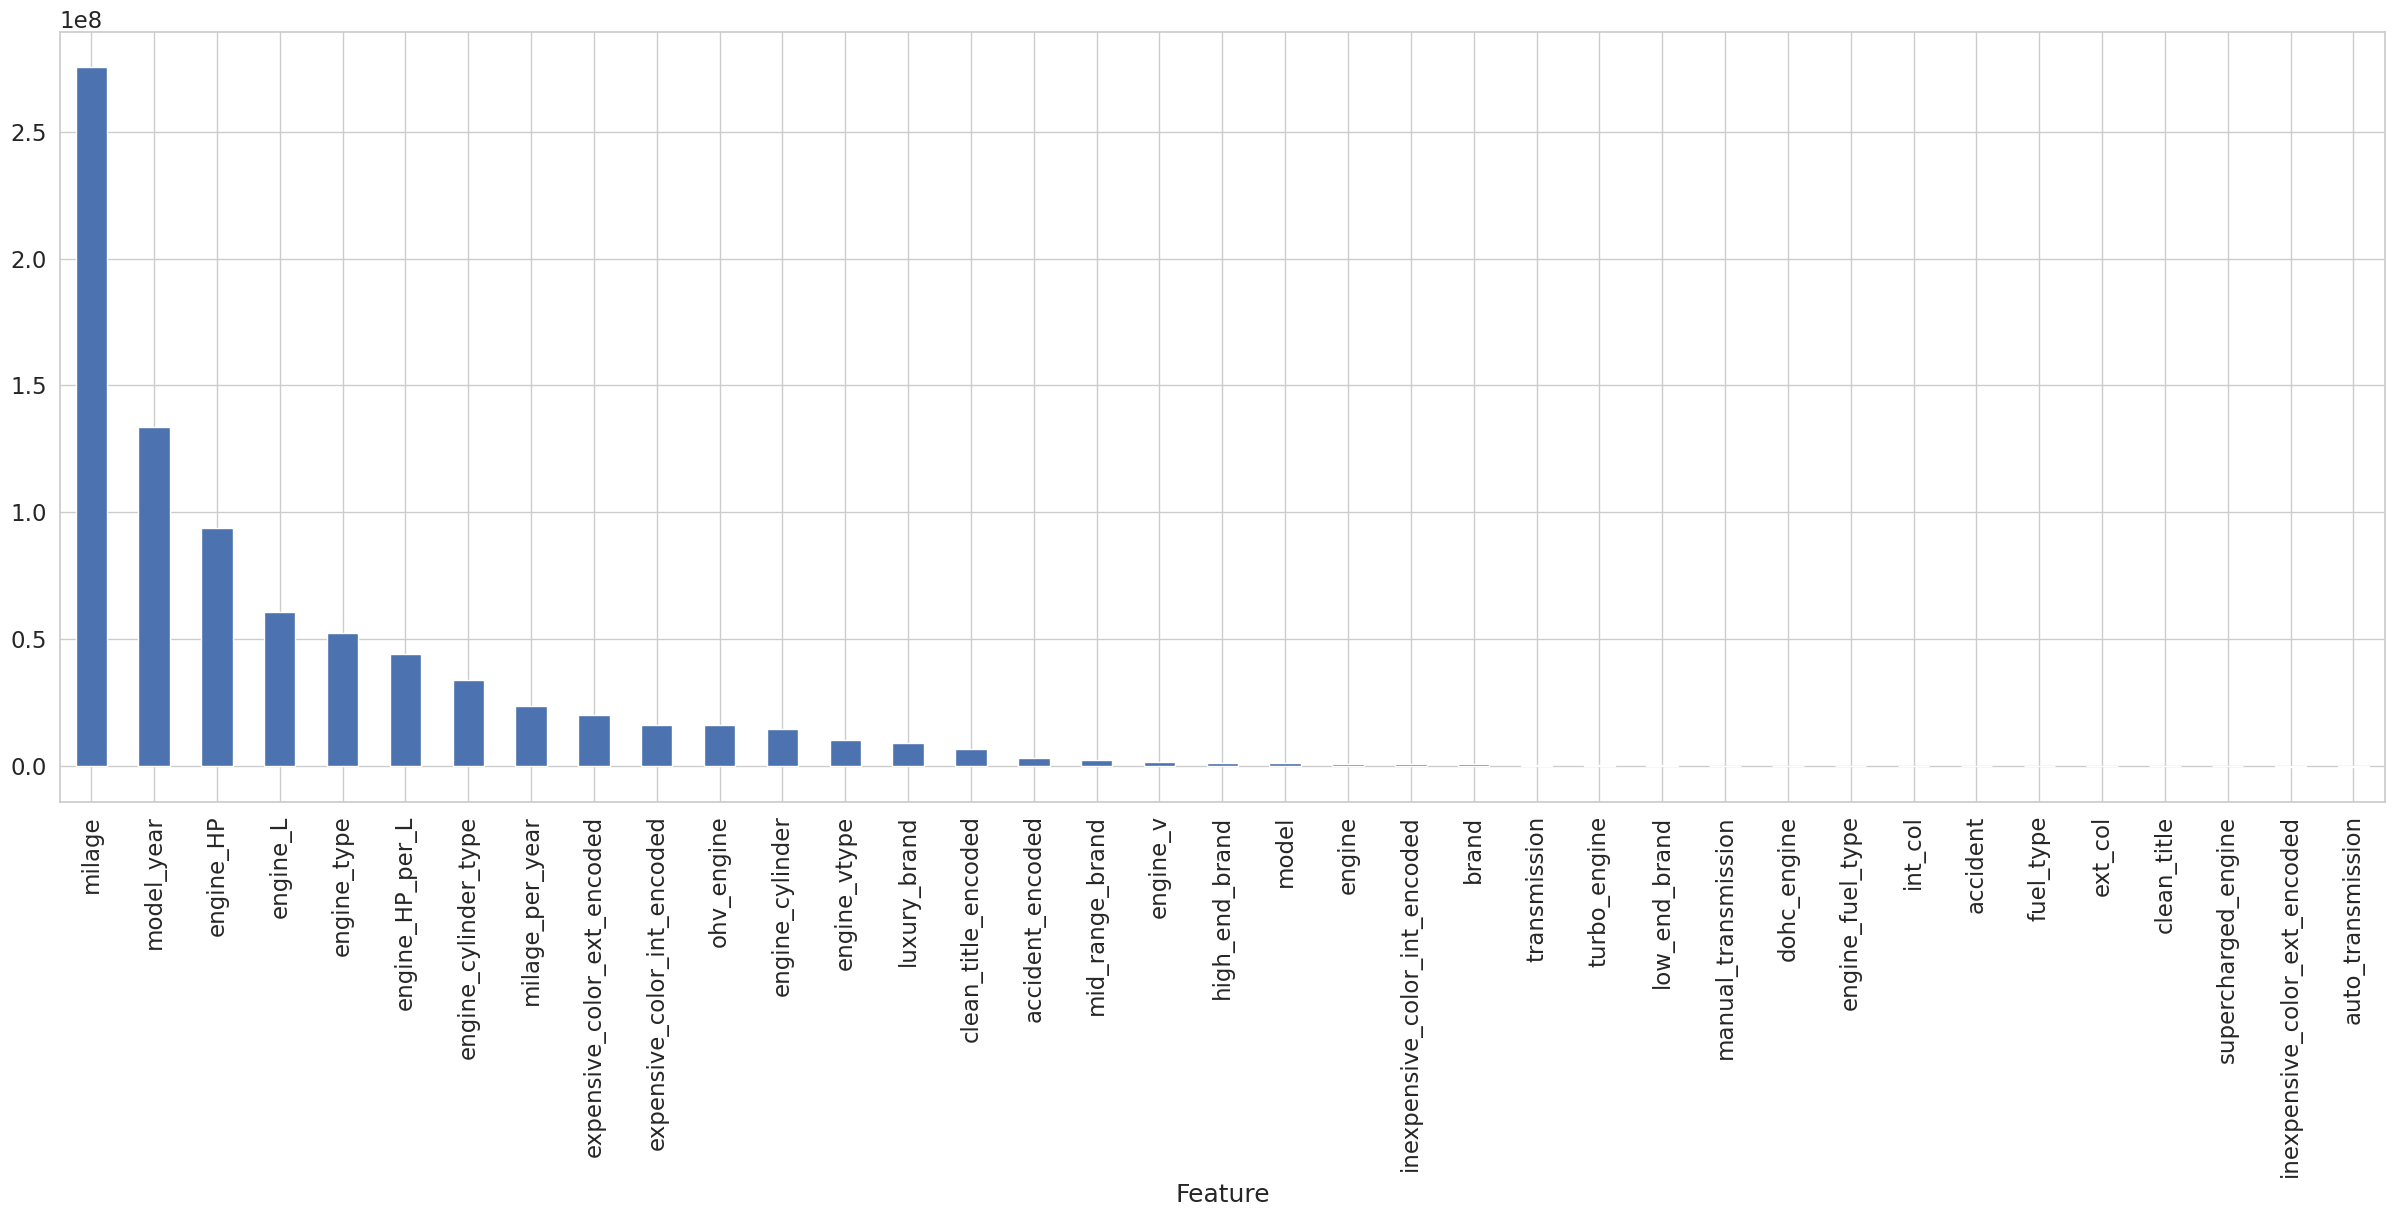

In [66]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
explainer = SSWARM(automl)
shap_values = explainer.shap_values(val_data, n_jobs=N_THREADS)

 89%|████████▉ | 2663/3000 [24:18<01:14,  4.51it/s]

/tmp/ipykernel_117380/1843962766.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, val_data[explainer.used_feats])


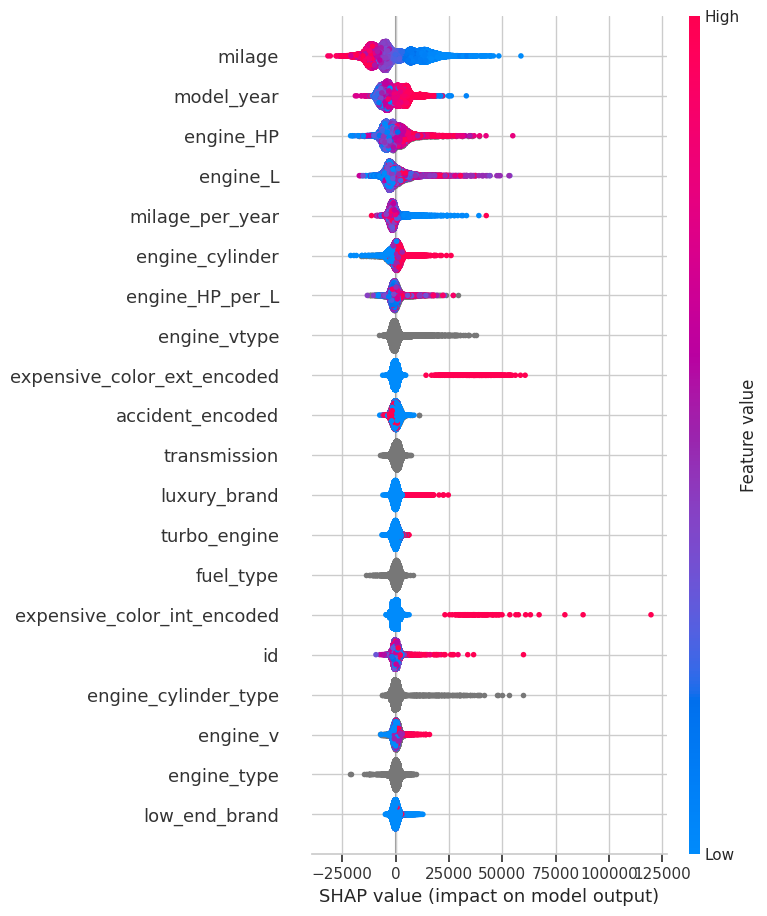

In [ ]:
import shap
shap.summary_plot(shap_values, val_data[explainer.used_feats])

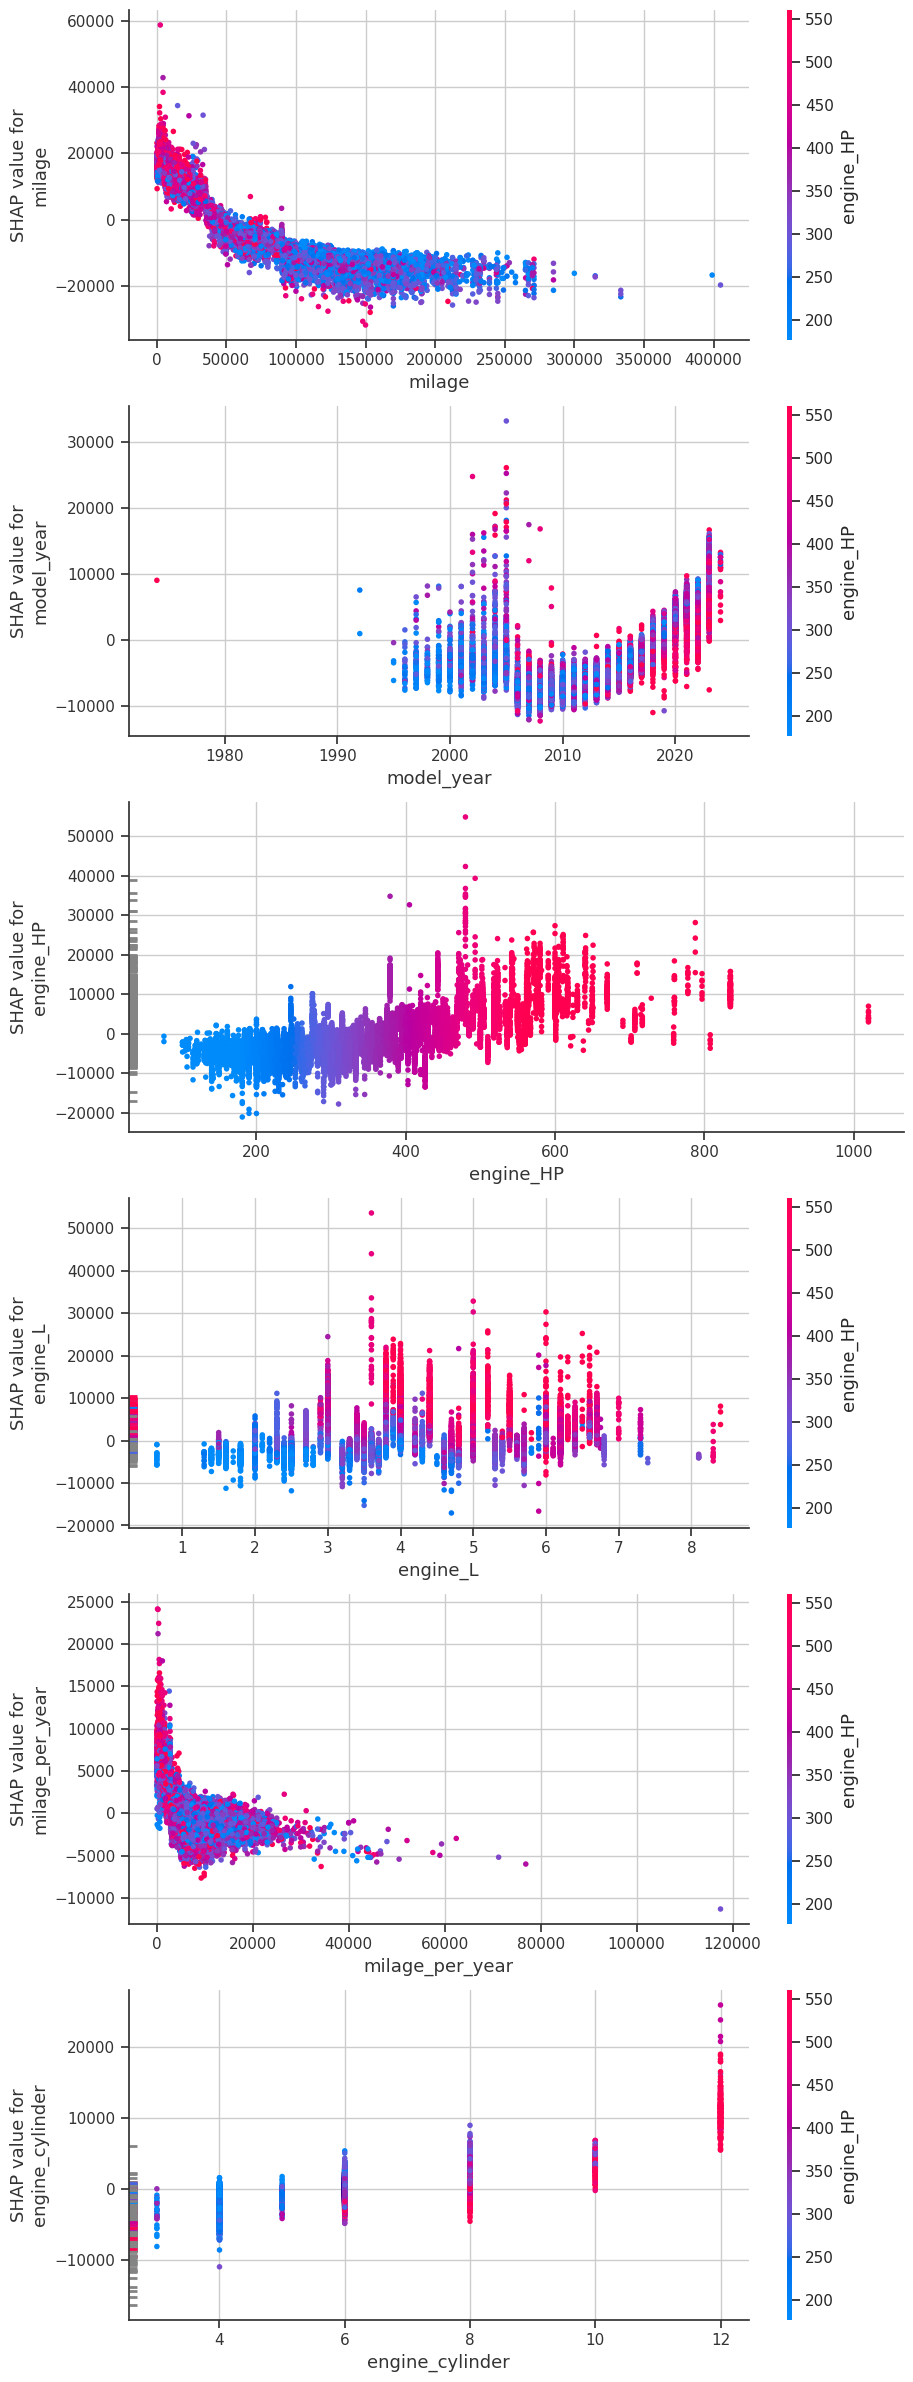

In [ ]:
feats = ["milage", "model_year", "engine_HP", "engine_L", "milage_per_year", 'engine_cylinder']
fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

for i, feat in enumerate(feats):
    shap.dependence_plot(feat, shap_values, val_data[explainer.used_feats],
                         show=False, ax=ax[i], interaction_index="engine_HP")

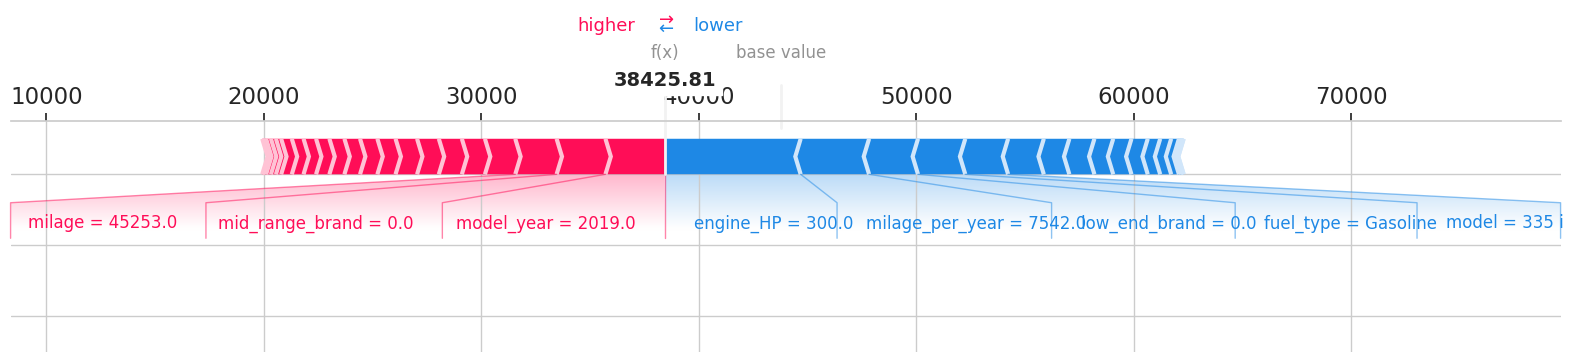

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], val_data[explainer.used_feats].iloc[0], matplotlib=True)

In [68]:
test_preds = automl.predict(test)

In [69]:
sub['price'] = test_preds.data[:,0]
sub.to_csv('lightautoml_submision.csv', index=None)

In [ ]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor()
stacking_model.fit(X=)

array([18328.693, 85008.78 , 55413.82 , ..., 23138.121, 17891.14 ,
       37193.38 ], dtype=float32)